In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.cluster import KMeans
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Naive Bayes Classifiers, Random Forest and Support Vector Machines algorithms. 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from sklearn.base import TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV


from tqdm import tqdm

In [17]:
data = pd.read_csv("data/CompleteDataset.csv", low_memory=False).drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])
data.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,2228,89,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,2154,92,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,2100,94,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,2291,88,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
5,R. Lewandowski,28,Poland,91,91,FC Bayern Munich,€92M,€355K,2143,79,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0


In [42]:
def value_to_float(x):
    x.split('€')[1]
    if type(x) == float or type(x) == int:
        return x
    if 'M' in x:
        return float(x.split('€')[1].replace('M','')) * 1000000
    if 'K' in x:
        return float(x.split('€')[1].replace('K','')) * 1000
    if '€' in x:
        return float(x.split('€')[1])
    return 0

def clean_stat(value):
    try:
        if '+' in value or '-' in value:
            base, mod = value.split('+') if '+' in value else value.split('-')
            mod = int(mod) if '+' in value else -int(mod)
            return int(base) + mod
        else:
            return int(value)
    except:
        return np.nan
    

def create_features(data):

    df = data.copy()

    columns_with_issues = ['Finishing', 'Composure', 'Dribbling', 'Shot power', 
                        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
                        'Stamina', 'Jumping', 'Ball control', 'Short passing']

    for c in columns_with_issues:
        df[c] = df[c].apply(clean_stat)

    df['Value'] = df['Value'].apply(value_to_float)
    df['Wage'] = df['Wage'].apply(value_to_float)

    df['Primary Position'] = df['Preferred Positions'].apply(lambda x: x.split()[0])
    df['Secondary Positions'] = df['Preferred Positions'].apply(lambda x: ' '.join(x.split()[1:]))

    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)

    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']

    df['isAttacker'] = np.where(df['Attack/Defend Ratio'] > 1, 1.0, 0.0)

    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)

    # df['Value per Overall'] = df['Value'] / df['Overall']
    # df['Wage per Overall'] = df['Wage'] / df['Overall']
    # df['Potential Gap'] = df['Potential'] - df['Overall']

    df['Age Group'] = pd.cut(
                            df['Age'], 
                            bins=[15, 20, 25, 30, 40, 50], 
                            labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend']
                            )
    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']
    # df['GK Score'] = df[['GK diving', 'GK reflexes', 'GK positioning']].mean(axis=1)


    # kmeans = KMeans(n_clusters=5, random_state=0)
    # df['Player Archetype'] = kmeans.fit_predict(df[['Overall', 'Potential', 'Value', 'Wage', 'Age']])

    df.drop_duplicates(inplace=True)

    return df.reset_index(drop=True)

df = create_features(data)

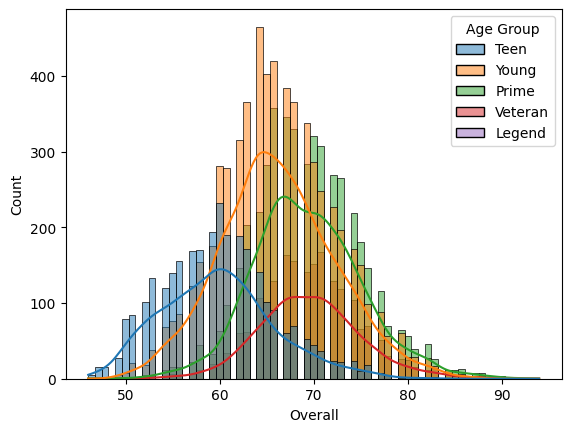

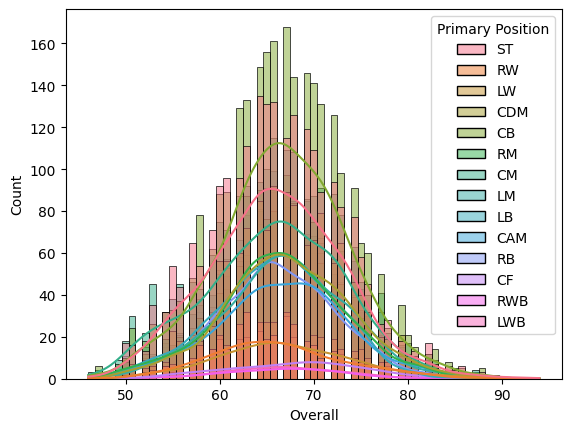

In [43]:
# Class imbalance
sns.histplot(data=df, x='Overall', hue='Age Group', kde=True)
plt.show()

sns.histplot(data=df, x='Overall', hue='Primary Position', kde=True)
plt.show()

C:\Users\vince\AppData\Local\Temp\ipykernel_56744\3907592428.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.clustermap(df.corr(), cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))


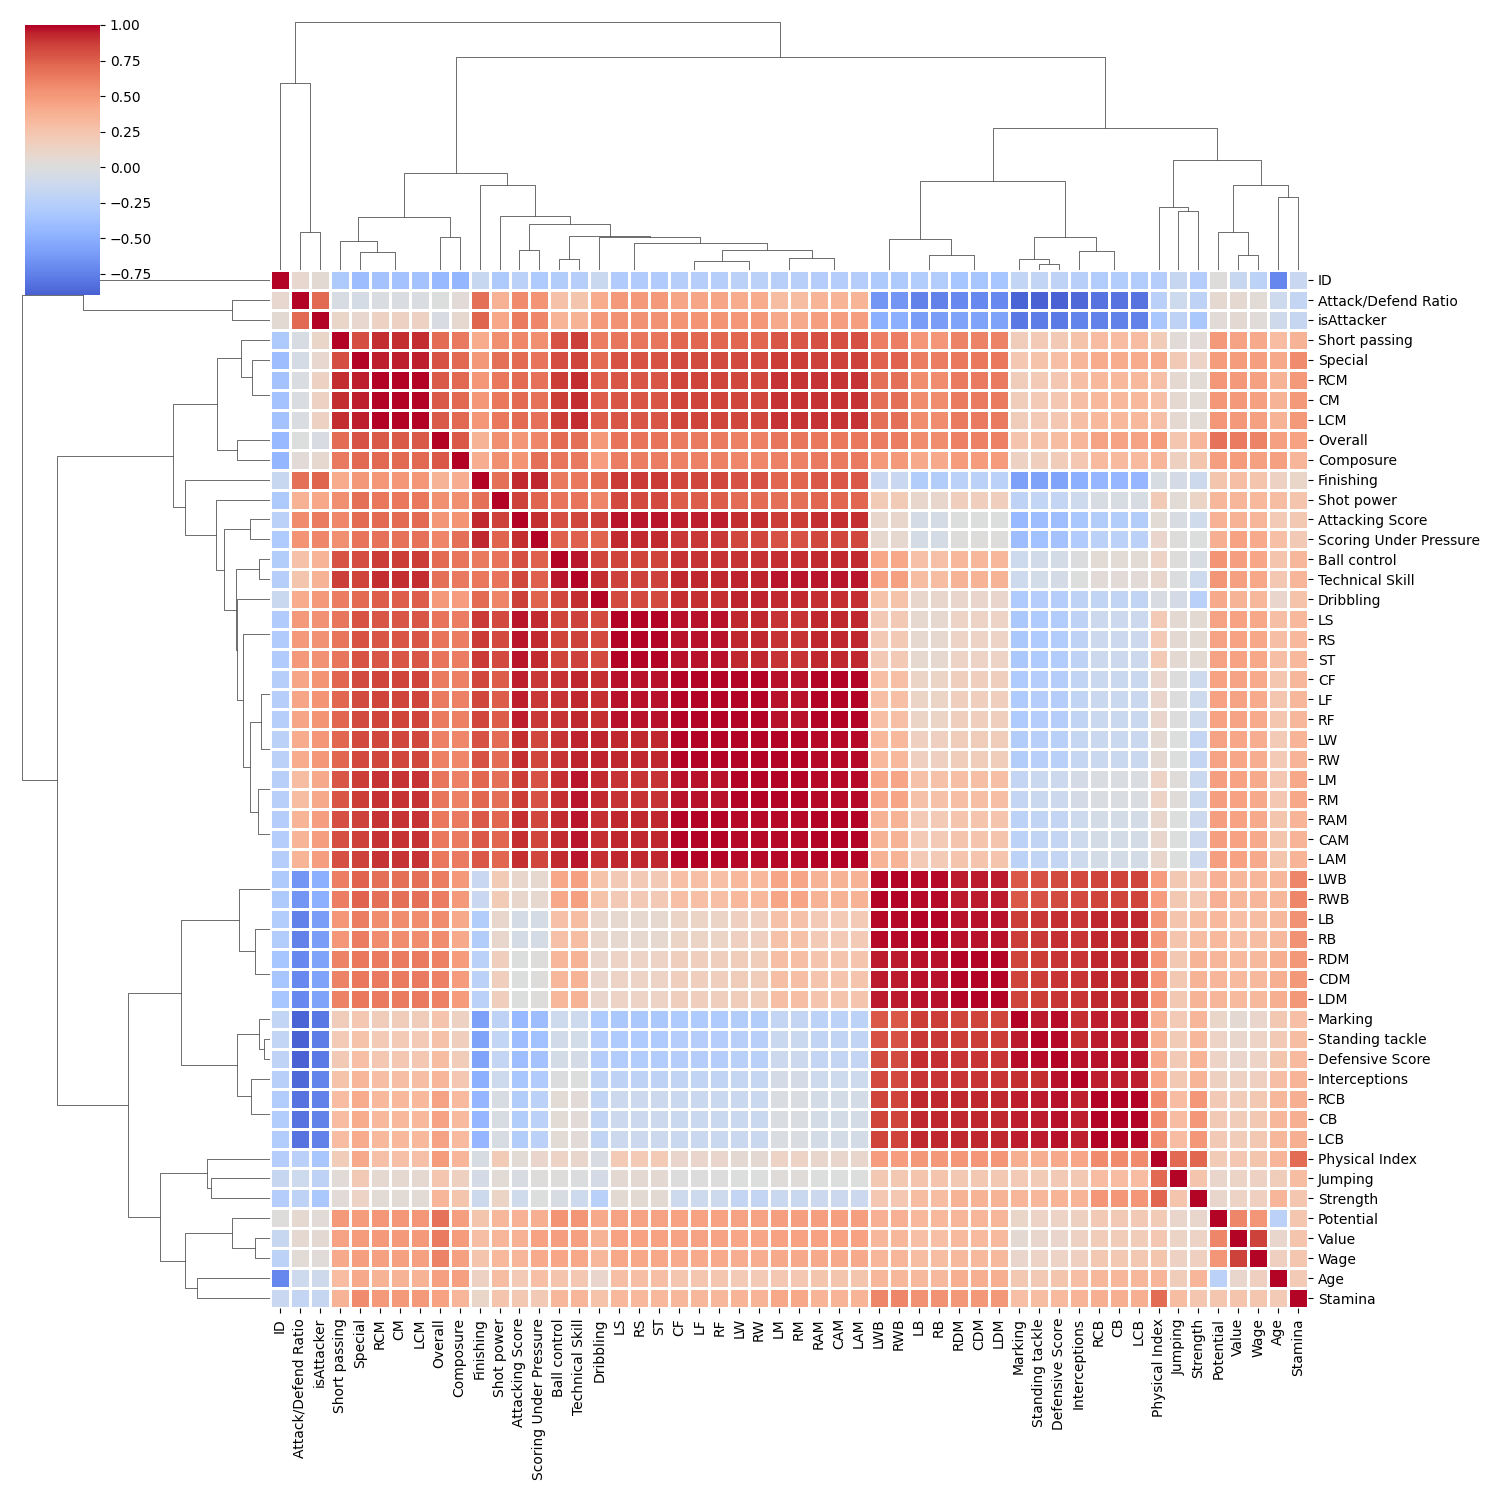

In [40]:
# HIERARCHICAL CLUSTERING CORRELATION
sns.clustermap(df.corr(), cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))
plt.show()

In [45]:
target = 'Overall'
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

subset_frac = 0.1

try:
    categorical_cols = categorical_cols.drop(target)
except:
    pass
try:
    numerical_cols = numerical_cols.drop(target)
except:
    pass

try:
    # Stratified sampling for classification
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target).sample(frac=subset_frac, random_state=42), 
        df[target].sample(frac=subset_frac, random_state=42), 
        stratify=df[target].sample(frac=subset_frac, random_state=42),
        random_state=42
        )
    print('Stratified sampling done for classification')
except:
    # No stratification for regression
    print('No stratification done for regression')
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=target).sample(frac=subset_frac, random_state=42), 
        df[target].sample(frac=subset_frac, random_state=42), 
        random_state=42
        )

No stratification done for regression


In [ ]:
correlation = df.corr()[target].sort_values(ascending=False)
correlation = correlation.drop(target)
correlation

In [ ]:
def model_pipeline(df, target, task_type, subset_frac=0.1, random_state=42):
    import logging
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.svm import SVR, SVC
    from lightgbm import LGBMRegressor, LGBMClassifier
    import joblib
    import os

    logging.basicConfig(level=logging.INFO)

    try:
        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = categorical_cols.drop(target)
    except:
        categorical_cols = []

    try:
        numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
        numerical_cols = numerical_cols.drop(target)
    except:
        numerical_cols = []

    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    if task_type == 'regression':
        models_list = [
            (RandomForestRegressor(random_state=42), {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20]
            }),
            (LinearRegression(), {
                'fit_intercept': [True, False]
            }),
            (SVR(), {
                'C': [0.1, 1.0],
                'kernel': ['linear', 'rbf']
            }),
            (LGBMRegressor(), {
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200]
            })
        ]
        scoring_metric = 'neg_mean_squared_error'
        test_metrics = ['MSE', 'R2']
    elif task_type == 'classification':
        models_list = [
            (RandomForestClassifier(random_state=42), {
                'n_estimators': [100, 200],
                'max_depth': [None, 10, 20]
            }),
            (LogisticRegression(random_state=42), {
                'C': [0.1, 1.0],
                'penalty': ['l1', 'l2']
            }),
            (SVC(random_state=42), {
                'C': [0.1, 1.0],
                'kernel': ['linear', 'rbf']
            }),
            (LGBMClassifier(), {
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200]
            })
        ]
        scoring_metric = 'accuracy'
        test_metrics = ['Accuracy', 'Classification Report']
    else:
        raise ValueError("task_type must be either 'regression' or 'classification'")

    df_sampled = df.sample(frac=subset_frac, random_state=random_state)
    X = df_sampled.drop(columns=target)
    y = df_sampled[target]

    if task_type == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    pipelines = [
        Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]) for model, _ in models_list
    ]

    param_grids = [
        {
            f'model__{param}': values for param, values in params.items()
        } for model, params in models_list
    ]

    results = []

    for i, (pipeline, param_grid) in tqdm(enumerate(zip(pipelines, param_grids))):
        try:
            grid_search = GridSearchCV(pipeline, 
                                       param_grid, 
                                       cv=5, 
                                       scoring=scoring_metric, 
                                       n_jobs=-1)
            
            grid_search.fit(X_train, y_train)

            best_score = -grid_search.best_score_ if scoring_metric == 'neg_mean_squared_error' else grid_search.best_score_
            results.append({
                'model': pipeline.named_steps['model'].__class__.__name__,
                'best_score': best_score,
                'best_params': grid_search.best_params_
            })

            print(f"Best score for {pipeline.named_steps['model'].__class__.__name__}: {best_score:.4f}")
            print(f"Best parameters: {grid_search.best_params_}")
            print()

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            if task_type == 'regression':
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                print(f"Test Set Metrics for {pipeline.named_steps['model'].__class__.__name__}:")
                print(f"MSE: {mse:.4f}, R2: {r2:.4f}")
            else:
                accuracy = accuracy_score(y_test, y_pred)
                # f1 = f1_score(y_test, y_pred, average='weighted')
                # recall = recall_score(y_test, y_pred, average='weighted')
                print(f"Test Set Metrics for {pipeline.named_steps['model'].__class__.__name__}:")
                print(f"Accuracy: {accuracy:.4f}")
                print(classification_report(y_test, y_pred))

            print("------------------------------")

        except Exception as e:
            print(f"An error occurred with model {i+1}: {e}")

    if scoring_metric == 'neg_mean_squared_error':
        best_model_result = min(results, key=lambda x: x['best_score'])
    else:
        best_model_result = max(results, key=lambda x: x['best_score'])

    print(f"Best model: {best_model_result['model']} with score: {best_model_result['best_score']:.4f}")
    print(f"Best parameters: {best_model_result['best_params']}")

    best_model_name = f"models_assignement_1/best_model_{task_type}.joblib"
    joblib.dump(best_model_result['model'], best_model_name)
    print(f"Best model saved as {best_model_name}")

    return y_pred


In [49]:
model_pipeline(df,
               target='Overall', 
               task_type='regression', 
               subset_frac=0.1, random_state=42)

1it [00:34, 34.54s/it]

Best score for RandomForestRegressor: 0.5346
Best parameters: {'model__max_depth': None, 'model__n_estimators': 100}

Test Set Metrics for RandomForestRegressor:
MSE: 0.3874, R2: 0.9888
------------------------------
Best score for LinearRegression: 3.7820
Best parameters: {'model__fit_intercept': True}

Test Set Metrics for LinearRegression:
MSE: 2.9338, R2: 0.9148
------------------------------


3it [00:35,  9.14s/it]

Best score for SVR: 3.4192
Best parameters: {'model__C': 1.0, 'model__kernel': 'rbf'}

Test Set Metrics for SVR:
MSE: 1.8653, R2: 0.9458
------------------------------


c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\vince\.conda\envs\env_dev_1\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
4it [00:39,  7.49s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3957
[LightGBM] [Info] Number of data points in the train set: 1256, number of used features: 51
[LightGBM] [Info] Start training from score 66.421975
Best score for LGBMRegressor: 0.5281
Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 200}

Test Set Metrics for LGBMRegressor:
MSE: 0.3562, R2: 0.9897
------------------------------


4it [00:39,  9.85s/it]

Best model: LGBMRegressor with score: 0.5281
Best parameters: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
Best model saved as models_assignement_1/best_model_regression.joblib


In [ ]:
load_model = joblib.load("models_assignement_1/best_model_regression.joblib")

In [ ]:
import smogn

def apply_smogn(X_train, y_train, target):
    data = X_train.copy()
    data[target] = y_train
    data.reset_index(drop=True, inplace=True)
    data = data.select_dtypes(include=['number'])
    data_smogn = smogn.smoter(
        data=data,
        y=target,
        k=3,
        samp_method='extreme',
        rel_thres=0.80,
        rel_method='auto',
        rel_xtrm_type='both',
        rel_coef=2.25
    )

    X_train_smogn = data_smogn.drop(columns=[target])
    y_train_smogn = data_smogn[target]
    return X_train_smogn, y_train_smogn

X_train_smogn, y_train_smogn = apply_smogn(X_train, y_train, target='Value')


In [ ]:
X_train_smogn